In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from tqdm import tqdm

# Load dataset into a dataframe

In [2]:
trainset = pd.read_csv('/content/aps_failure_training_set.csv', skiprows=19)
testset = pd.read_csv('/content/aps_failure_test_set.csv', skiprows=19)
trainset.shape, testset.shape

((60000, 171), (16000, 171))

In [3]:
trainset.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [4]:
trainset.replace('na', np.nan, inplace=True)

In [5]:
num_duplicated = len(trainset[trainset.duplicated()])
print(f'STATUS: There are/is {num_duplicated} duplicated rows')

STATUS: There are/is 0 duplicated rows


In [6]:
if not trainset['class'].isna().any():
    print('STATUS: There is no null value in class column')
    print(trainset['class'].value_counts())
else:
    print(f'STATUS: There are/is {len(trainset[trainset["class"].isna()])} null value in class column')

STATUS: There is no null value in class column
neg    59000
pos     1000
Name: class, dtype: int64


In [7]:
columns_with_null_values = 0
for column in trainset.columns:
    if trainset[column].isna().any():
        columns_with_null_values += 1
print(f'STATUS: {columns_with_null_values}/{len(trainset.columns)} columns contains null values')

STATUS: 169/171 columns contains null values


In [8]:
p_of_null = {
    'column': [],
    'count_of_null':[],
    'p_of_null': []
}

for column in trainset.columns[1:]:
    p_of_null['column'].append(column)
    p_of_null['count_of_null'].append(trainset[column].isna().sum())
    p_of_null['p_of_null'].append(trainset[column].isna().mean() * 100)

df_p_of_null = pd.DataFrame(p_of_null)
df_p_of_null.sort_values('p_of_null', inplace=True)
df_p_of_null

,column,count_of_null,p_of_null
0,aa_000,0,0.000000
80,bt_000,167,0.278333
96,ck_000,338,0.563333
95,cj_000,338,0.563333
94,ci_000,338,0.563333
...,...,...,...
112,cr_000,46329,77.215000
75,bo_000,46333,77.221667
76,bp_000,47740,79.566667
77,bq_000,48722,81.203333


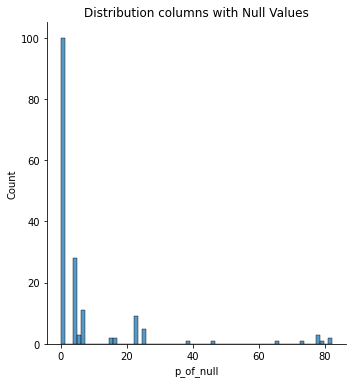

In [9]:
variable = df_p_of_null['p_of_null'].values
ax = sns.displot(variable)
plt.title('Distribution columns with Null Values')
plt.xlabel('p_of_null')
plt.show()

In [10]:
columns_to_drop = df_p_of_null[df_p_of_null.p_of_null >= 50].column
columns_to_drop

73     bm_000
74     bn_000
1      ab_000
112    cr_000
75     bo_000
76     bp_000
77     bq_000
78     br_000
Name: column, dtype: object

In [11]:
trainset.drop(columns_to_drop, axis=1, inplace=True)
trainset

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,2130706438,280,0,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,0,NaN,0,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,228,100,0,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,70,66,0,10,0,0,0,318,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,1368,458,0,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,664,186,0,0,0,0,0,2564,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,2130706538,224,0,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,2130706432,18,0,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,2130706432,494,0,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


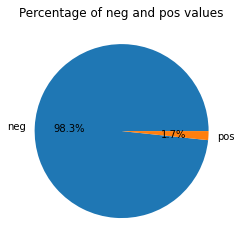

In [12]:
# count the frequency of each value in the series
counts = trainset['class'].value_counts()

# calculate the percentage of each value in the series
percentages = counts / len(trainset['class']) * 100

# create a pie chart to show the percentages
labels = percentages.index.tolist()
plt.pie(percentages, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of neg and pos values')
plt.show()

In [13]:
X = trainset.drop('class', axis=1)
Y = trainset[['class']]

int_cols = []
float_cols = []
object_cols = []
for col in tqdm(X.columns):
    try:
        X[col] = pd.to_numeric(X[col])
        if (X[col] % 1 > 0).any(): float_cols.append(col)
        else: int_cols.append(col)
    except: object_cols.append(col)

100%|██████████| 162/162 [00:20<00:00,  7.73it/s]


In [14]:
print('int_cols:', len(int_cols))
print('float_cols:', len(float_cols))
print('object_cols:', len(object_cols))

int_cols: 157
float_cols: 5
object_cols: 0


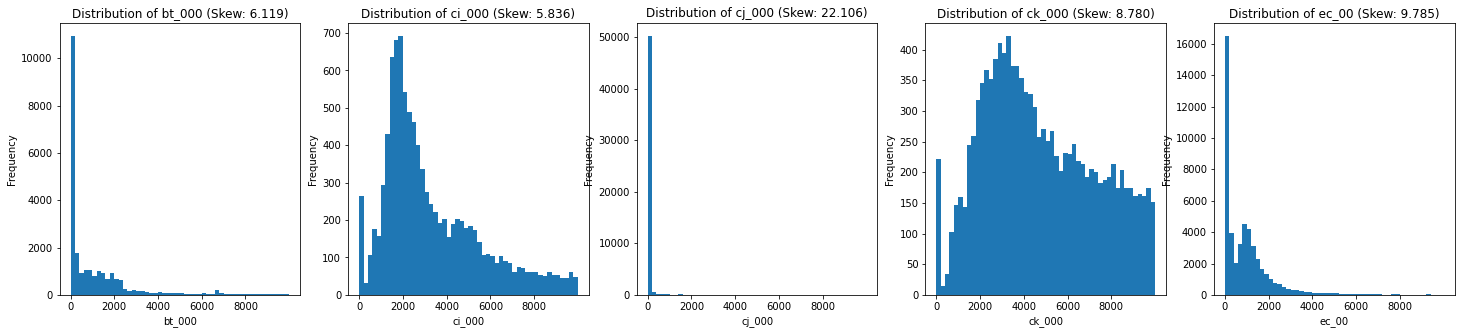

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=len(float_cols), figsize=(25, 5))
n_bins = 50
max_range = 10000
check_bin = max_range + n_bins
check_bin2 = int(max_range / n_bins)

for i, ax in enumerate(axes.flat):
    ax.hist(X[float_cols[i]].values, bins=n_bins, range = (0, 10000))
    ax.set_title(f'Distribution of {float_cols[i]} (Skew: {X[float_cols[i]].skew():.3f})')
    ax.set_xticks(np.arange(0, max_range, 10 * check_bin2))
    ax.set_ylabel(f"Frequency")
    ax.set_xlabel(float_cols[i])
plt.show()